In [128]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [129]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data < 200
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(21, 256) (21,)


(21, 256)


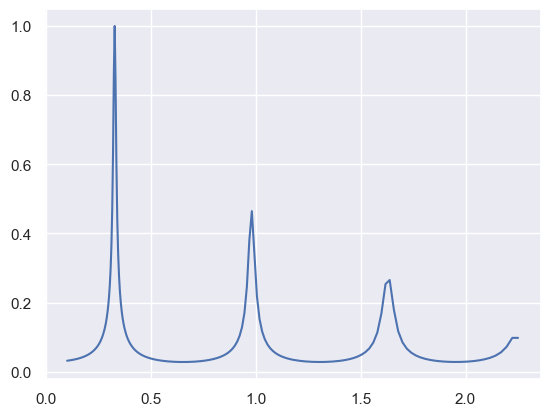

In [130]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
TTF_values = scaler.fit_transform(TTF_data.T).T
print(TTF_values.shape)

plt.plot(freq_data, TTF_values[-1,:], label="TTF")

In [131]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(1)
        return input_data, target_data

In [132]:
dataset = TTF_dataset(TTF_values, Vs_data)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  16 2 3
Number of batches:  8 1 2


# Model

In [133]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=64, num_heads=8, num_layers=6):
        super(TransformerModel, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim * 30, output_dim)  # Adjust the input dimension of the fully connected layer

    def forward(self, src):
        src = self.embedding(src)
        encoded_src = self.transformer_encoder(src)
        encoded_src = encoded_src.flatten(start_dim=1)  # Flatten the sequence dimension
        output = self.fc(encoded_src)
        output = output.unsqueeze(-1)  # Add the last dimension to match the desired shape
        return output



In [134]:
# Define the model
input_dim = 1
output_dim = 256
embed_dim = 64  # Ensure this is divisible by num_heads
num_heads = 8

model = TransformerModel(input_dim, output_dim, embed_dim, num_heads)

# Try it with a batch
X, y = next(iter(train_loader))

print(X.shape, y.shape)
output = model(X)
print(output.shape)
assert output.shape == y.shape, "Output shape is not correct"
loss_fn = nn.L1Loss()
print(loss_fn(output, y))

torch.Size([2, 30, 1]) torch.Size([2, 256, 1])
torch.Size([2, 256, 1])
tensor(0.4645, grad_fn=<MeanBackward0>)


c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [135]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [136]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50, clipping=True):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None
    best_loss = float('inf')

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 250 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu"):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [137]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Define the exponential learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
factor=0.5, patience=400, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08)

# Training
num_epochs = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

Device:  cuda


In [138]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1100, clipping=True)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   0%|          | 2/10000 [00:00<29:46,  5.60epoch/s]

Epoch 0, Train Loss: 0.3380283806473017, Val Loss: 0.20382246375083923, LR: 0.0001


Training:   3%|▎         | 252/10000 [00:38<24:11,  6.71epoch/s, EarlyStopping counter: 4 out of 1100] 

Epoch 250, Train Loss: 0.1314982520416379, Val Loss: 0.12214362621307373, LR: 0.0001


Training:   5%|▌         | 502/10000 [01:13<21:38,  7.32epoch/s, EarlyStopping counter: 239 out of 1100]

Epoch 500, Train Loss: 0.11789613869041204, Val Loss: 0.11804816126823425, LR: 0.0001


Training:   8%|▊         | 752/10000 [01:56<25:55,  5.94epoch/s, EarlyStopping counter: 489 out of 1100]

Epoch 750, Train Loss: 0.10685576871037483, Val Loss: 0.10992599278688431, LR: 5e-05


Training:  10%|█         | 1002/10000 [02:33<20:40,  7.25epoch/s, EarlyStopping counter: 739 out of 1100]

Epoch 1000, Train Loss: 0.11630907095968723, Val Loss: 0.11220353096723557, LR: 5e-05


Training:  13%|█▎        | 1252/10000 [03:10<20:30,  7.11epoch/s, EarlyStopping counter: 989 out of 1100]

Epoch 1250, Train Loss: 0.12323667481541634, Val Loss: 0.11284097284078598, LR: 2.5e-05


Training:  14%|█▎        | 1362/10000 [03:30<22:17,  6.46epoch/s, EarlyStopping counter: 1100 out of 1100]

Early stopping


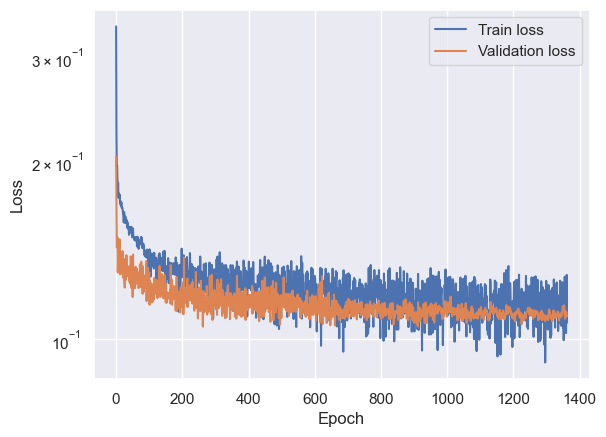

In [139]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [140]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.12959260493516922


In [141]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Squeeze the last dimension
target = np.squeeze(target)
predicted = np.squeeze(predicted)
Vs_data = np.squeeze(Vs_data)

print(target.shape, predicted.shape, Vs_data.shape)

(3, 256) (3, 256) (3, 30)


In [142]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i, " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0  :  0.5331009305142516
Correlation factor for TTF  1  :  0.545287296709148
Correlation factor for TTF  2  :  0.2551831329823244


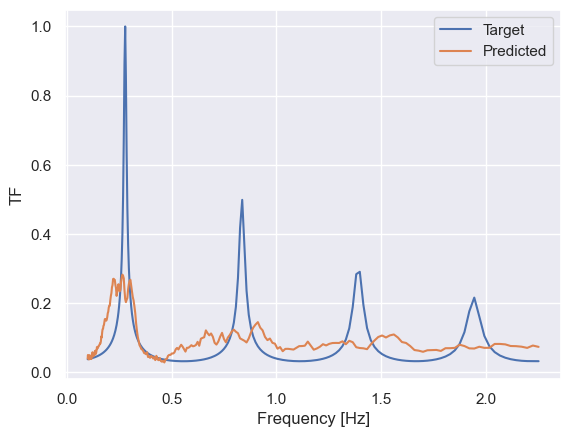

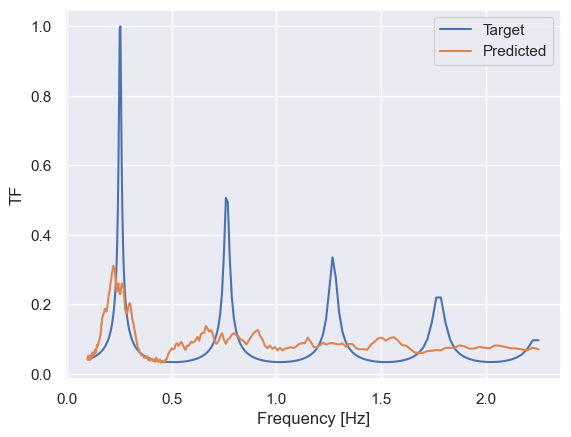

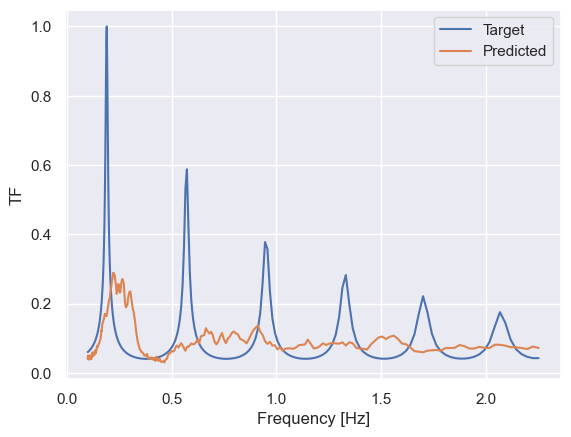

In [143]:
for i in range(target.shape[0]):
    plt.plot(freq_data, target[i,:], label="Target")
    plt.plot(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.legend()
    plt.show()